In [63]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
import warnings
warnings.simplefilter('ignore')
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
import os
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()
os.listdir('../data')

['dataset.pkl', 'tag_cleaned.csv']

# 讀取資料

In [64]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag = tag.loc[tag.category=='可控制因子']

In [65]:
data = joblib.load('../data/dataset.pkl')
data.keys()

dict_keys(['state', 'action', 'output', 'stream', 'idx', 'mm_state', 'mm_action', 'mm_output', 'mm_stream', 'state_col', 'action_col', 'output_col', 'stream_col'])

In [66]:
data['action_col']

['MLPAP_FQ-0619.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_FR-0632.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-1734.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TJ-0881.PV',
 'MLPAP_TJ-0757B.PV',
 '濃度']

# 轉化成張量格式

In [67]:
n = 0 
state = torch.FloatTensor(data['state'][n:]).cuda()
action = torch.FloatTensor(data['action'][n:]).cuda()
output = torch.FloatTensor(data['output'][n:]).cuda()
stream = torch.FloatTensor(data['stream'][n:]).cuda()

# 切分資料

In [68]:
sp1 = int(len(state)*0.8)
sp2 = int(len(state)*0.9)
print(sp1,sp2)

47370 53291


In [69]:
data['idx'][sp2:][0],data['idx'][sp2:][-1]

(Timestamp('2020-07-27 13:50:00'), Timestamp('2020-09-09 23:40:00'))

# 製作資料iter

In [70]:
train = torch.utils.data.TensorDataset(state[:sp1],action[:sp1],output[:sp1],stream[:sp1])
valid = torch.utils.data.TensorDataset(state[sp2:],action[sp2:],output[sp2:],stream[sp2:])
test = torch.utils.data.TensorDataset(state[sp2:],action[sp2:],output[sp2:],stream[sp2:])

train_iter = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)

In [71]:
print(action.shape)
time_step = action.shape[1]
num_sensor = action.shape[2]

torch.Size([59213, 36, 12])


# 建立神經網路

In [72]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.time_step = time_step
        self.num_sensor = num_sensor
        self.h_size = 128
        
        self.output_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Dropout(0.2),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.stream_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.conv_layer = nn.Sequential(nn.Conv1d(self.num_sensor,self.h_size-1,kernel_size = 36),
                                        nn.ReLU(),
                                       )
        
        self.fc_layer = nn.Sequential(nn.Linear(self.h_size+1,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,self.h_size),
                                         )
        
    def forward(self,state,action):
        batch_size = state.shape[0]
        
        # 動作
        action = self.conv_layer(action.permute(0,2,1)).reshape(batch_size,-1)
        
        # 組合狀態和動作
        combine = torch.cat((state,action),dim=-1)
        
        # 流過一層全連結
        combine = self.fc_layer(combine)
        
        # 預測出料跟蒸氣
        output = self.output_layer(combine)
        stream = self.stream_layer(combine)
        
        return F.sigmoid(output),F.sigmoid(stream)

In [73]:
# 權重初始化方法
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0.1)
        except:
            pass

In [74]:
net = Critic().cuda()
net.apply(init_weights)

Critic(
  (output_layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
  (stream_layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conv_layer): Sequential(
    (0): Conv1d(12, 127, kernel_size=(36,), stride=(1,))
    (1): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

# 前向傳遞測試

In [75]:
a,b = net(state,action)
print(a.shape)
print(b.shape)

torch.Size([59213, 1])
torch.Size([59213, 1])


# tensorboard

In [76]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (test.tensors[0:2]))

# 損失函數 跟 優化器

In [77]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)

In [78]:
from torch.nn import L1Loss

l1loss = L1Loss()
def loss_function(output,stream,target_output,target_stream):
    loss = l1loss(output,target_output)
    return loss.mean()    

# 訓練和評估流程

In [79]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for state,action,output,stream in train_iter:
            output_pred,stream_pred = net(state,action)
            loss = loss_function(output_pred,stream_pred,output,stream)
            train_loss += loss.item()
            i += 1
            
            # update model
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # eval model (afater update model)
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for state,action,output,stream in valid_iter:
                output_pred,stream_pred = net(state,action)
                loss = loss_function(output_pred,stream_pred,output,stream)
                val_loss += loss.item()
                j += 1
        
        # caculate avg_loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best_model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            best_net = deepcopy(net) #backup the model(deepcopy)
            print('model recorded!')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(
            epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    return best_net.eval()

model recorded!
epochs 0 train_avg_loss 0.0269 valid_avg_loss 0.0435
model recorded!
epochs 1 train_avg_loss 0.0176 valid_avg_loss 0.0174
model recorded!
epochs 2 train_avg_loss 0.0170 valid_avg_loss 0.0166
epochs 3 train_avg_loss 0.0163 valid_avg_loss 0.0234
epochs 4 train_avg_loss 0.0158 valid_avg_loss 0.0242
model recorded!
epochs 5 train_avg_loss 0.0152 valid_avg_loss 0.0109
epochs 6 train_avg_loss 0.0151 valid_avg_loss 0.0256
epochs 7 train_avg_loss 0.0146 valid_avg_loss 0.0387
epochs 8 train_avg_loss 0.0140 valid_avg_loss 0.0361
epochs 9 train_avg_loss 0.0141 valid_avg_loss 0.0273
epochs 10 train_avg_loss 0.0137 valid_avg_loss 0.0686
epochs 11 train_avg_loss 0.0134 valid_avg_loss 0.0378
epochs 12 train_avg_loss 0.0131 valid_avg_loss 0.0368
epochs 13 train_avg_loss 0.0134 valid_avg_loss 0.0588
epochs 14 train_avg_loss 0.0129 valid_avg_loss 0.0440
epochs 15 train_avg_loss 0.0125 valid_avg_loss 0.0663
epochs 16 train_avg_loss 0.0126 valid_avg_loss 0.0388
epochs 17 train_avg_loss 0.0

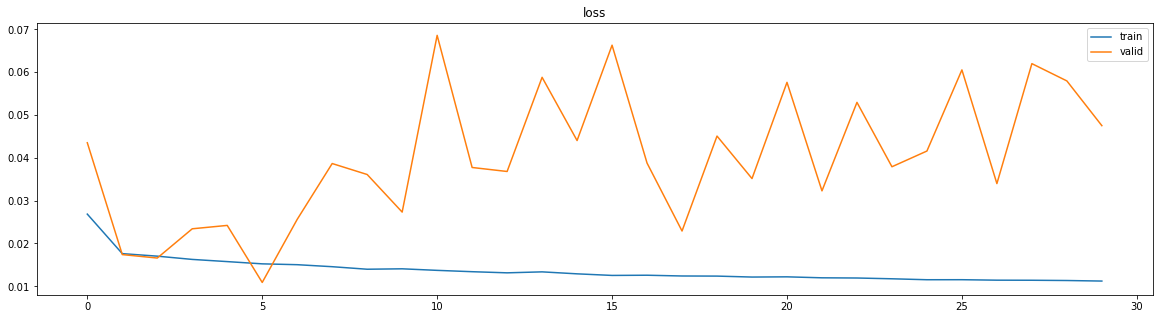

In [80]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=30)

# 產生預測值

In [81]:
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

def mape(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()*100

In [82]:
def make_prediction(state,action,output,streamn):
    
    y_pred = net(state,action)[0].detach().cpu().numpy()
    y_pred = data['mm_output'].inverse_transform(y_pred).ravel()
    
    y_pred2 = net(state,action)[1].detach().cpu().numpy()
    y_pred2 = data['mm_stream'].inverse_transform(y_pred2)
    
    y_real = output.detach().cpu().numpy()
    y_real = data['mm_output'].inverse_transform(y_real).ravel()
    
    y_real2 = stream.detach().cpu().numpy()
    y_real2 = data['mm_stream'].inverse_transform(y_real2)
    
    feed = action.detach().cpu().numpy()
    temp = [data['mm_action'].inverse_transform(feed[i]) for i in range(len(feed))]
    feed = np.array(temp)[:,:,0][:,0]
    
    table = pd.DataFrame()
    table['0619'] = feed
    table['0997_real'] = y_real
    table['0997_pred'] = y_pred
    table['真實單耗'] = feed/y_real
    table['預測單耗'] = feed/y_pred
    table['真實蒸氣'] = y_real2
    table['預測蒸氣'] = y_pred2
    
    return table

In [83]:
def make_metric(table):
    
    metric = pd.DataFrame(index=[0],columns=['R2(出料)','RMSE(出料)','MAPE(出料)'])
    metric['R2(出料)'] = r2_score(table['0997_real'],table['0997_pred'])
    metric['RMSE(出料)'] = sqrt(mean_squared_error(table['0997_real'],table['0997_pred']))
    metric['MAPE(出料)'] = mape(table['0997_real'],table['0997_pred'])
    metric.index.name = '出料'
    
    metric2 = pd.DataFrame(index=[0],columns=['R2','RMSE','MAPE'])
    metric2['R2'] = r2_score(table['真實蒸氣'],table['預測蒸氣'])
    metric2['RMSE'] = sqrt(mean_squared_error(table['真實蒸氣'],table['預測蒸氣']))
    metric2['MAPE'] = mape(table['真實蒸氣'],table['預測蒸氣'])
    metric2.index.name = '蒸氣'
    
    return metric,metric2

# 模型在訓練集上的表現

In [84]:
state ,action, output, stream = train_iter.dataset.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(出料),MAPE(出料)
出料,,,
0,0.960186,123.081492,1.020254


In [85]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,-0.465726,5353.776051,9.717167


In [86]:
table.sort_values(by='0997_real')

,0619,0997_real,0997_pred,真實單耗,預測單耗,真實蒸氣,預測蒸氣
136,3039.487305,3305.838867,4238.514160,0.919430,0.717112,25556.662109,36927.320312
137,3062.499512,3306.236816,4243.685547,0.926280,0.721660,25692.058594,36929.863281
138,3084.264648,3307.345215,4249.015625,0.932550,0.725877,25837.283203,36933.507812
139,3096.171143,3308.608887,4254.221191,0.935792,0.727788,25895.546875,36936.046875
140,3107.109863,3308.882812,4259.372559,0.939021,0.729476,25929.017578,36938.148438
...,...,...,...,...,...,...,...
24011,7732.999512,8734.500000,8521.065430,0.885340,0.907516,48237.578125,41231.238281
24010,7732.999512,8734.500000,8521.205078,0.885340,0.907501,48219.601562,41232.582031
24028,7732.999512,8735.500000,8520.784180,0.885238,0.907546,48276.636719,41232.398438
24026,7732.999512,8735.500000,8520.587891,0.885238,0.907566,48281.625000,41231.839844


# 模型在測試集上的表現

In [87]:
state ,action, output, stream = test.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(出料),MAPE(出料)
出料,,,
0,0.956836,97.355843,0.968687


In [88]:
table.sort_values(by='0997_real')

,0619,0997_real,0997_pred,真實單耗,預測單耗,真實蒸氣,預測蒸氣
3689,5758.003418,6422.909180,6525.169434,0.896479,0.882430,34359.828125,36815.351562
3690,5758.443359,6422.933594,6525.429199,0.896544,0.882462,34364.687500,36815.179688
3688,5758.003418,6422.933594,6525.248535,0.896476,0.882419,34355.277344,36814.992188
3687,5758.003418,6422.993164,6525.190918,0.896467,0.882427,34355.015625,36815.027344
3691,5759.278320,6422.993164,6525.541016,0.896666,0.882575,34364.687500,36815.949219
...,...,...,...,...,...,...,...
5246,7292.918457,8294.637695,8017.975586,0.879233,0.909571,41284.750000,39114.000000
5245,7293.142090,8294.637695,8018.094238,0.879260,0.909585,41286.925781,39114.945312
5244,7293.142090,8294.637695,8018.138672,0.879260,0.909580,41276.941406,39114.429688
5243,7293.000000,8294.637695,8018.819336,0.879243,0.909486,41292.359375,39119.058594


In [89]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,0.529483,1599.628394,3.756857


# 保存

In [90]:
joblib.dump(net,'../model/Critic.pkl')
print('save done!')

save done!
